In [1]:
# Import Basic Libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
import math
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Import XGBoost Libraries
import xgboost as xgb

# Import Neural Network Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout,Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

2023-04-08 03:06:11.357497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 03:06:11.632933: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 03:06:11.671197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-08 03:06:11.671217: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Create function to calculate root mean square error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [3]:
# Read csv file
df=pd.read_csv('/home/tarunpreet/Desktop/Suraj/org_update.csv')


In [4]:
#Groupby dataframe 

newdf=df.groupby(['Month','Day']).agg({'Temp': ['mean'],'DHI':['mean'],'DNI':['mean'],'GHI':['mean'],
                                      'WindVel':['mean'],'Output_Power':['mean']})
newdf = newdf.reset_index()
newdf.columns=['Month','Day','Temp_Mean','DHI_Mean','DNI_Mean','GHI_Mean','WindVel_Mean','Output_Power_Mean']

In [5]:
# Drop unnecessary columns in dataset
newdf1=newdf.drop(labels=['Month','Day'],axis=1)
X_data=newdf1.drop(labels=['Output_Power_Mean'],axis=1)
Y_data=newdf1['Output_Power_Mean']

In [6]:
# Scale the dataset to ensure that features are within the same scale using Standard Scaler
Xscaler = StandardScaler()
Xscaler.fit(X_data)
SXdata= Xscaler.transform(X_data)

In [7]:
Yscaler = StandardScaler()
Y_data=Y_data.to_numpy().reshape(-1,1)
Yscaler.fit(Y_data)
SYdata= Yscaler.transform(Y_data)

In [8]:
# Split data into windows

window_size=10
predictions=1
x=[]
y=[]
for i in range(0, len(newdf1.index)-10, predictions):
    x.append(SXdata[i:window_size+i])
    y.append(SYdata[window_size+i])

In [9]:
# Train Test Split
X_train,X_test,Y_train,Y_test=train_test_split(np.array(x), np.array(y),test_size=0.20,random_state=42)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(255, 10, 5) (255, 1) (64, 10, 5) (64, 1)


In [10]:
#Reshape train and test set for LSTM Model

trainX_lstm = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])
testX_lstm = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

In [11]:
# Define Long Short Term Memory (LSTM Model)

print('model used in LSTM')
lstm = Sequential()
lstm.add(LSTM(input_shape = (10,5),units= 36,  activation='relu',return_sequences = True))
lstm.add(LSTM(10))
lstm.add(Dense(5, activation='relu'))
lstm.add(Dense(1))
lstm.summary()

model used in LSTM


2023-04-08 03:11:29.527099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-08 03:11:29.527361: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-08 03:11:29.527403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tarun): /proc/driver/nvidia/version does not exist
2023-04-08 03:11:29.528322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 36)            6048      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1880      
                                                                 
 dense (Dense)               (None, 5)                 55        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 7,989
Trainable params: 7,989
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Early stopping stop training once the model performance stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

Epoch 1/100
3/3 [==============================] - 3s 210ms/step - loss: 1.0430 - mae: 0.8553 - val_loss: 0.9534 - val_mae: 0.8059
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0022 - mae: 0.8336 - val_loss: 0.9275 - val_mae: 0.7936
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.9682 - mae: 0.8144 - val_loss: 0.9016 - val_mae: 0.7789
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 0.9377 - mae: 0.7944 - val_loss: 0.8758 - val_mae: 0.7624
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9104 - mae: 0.7734 - val_loss: 0.8524 - val_mae: 0.7452
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 0.8861 - mae: 0.7530 - val_loss: 0.8306 - val_mae: 0.7283
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8607 - mae: 0.7358 - val_loss: 0.8097 - val_mae: 0.7134
Epoch 8/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8374 - mae: 0.7

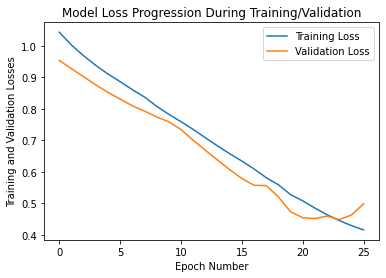

In [13]:
# Compile the model
lstm.compile(loss='mse', optimizer='adam',metrics=['mae'])
history_lstm = lstm.fit(trainX_lstm, Y_train, epochs = 100, verbose=1,validation_split=0.1,batch_size=100, callbacks=[early_stopping])
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [14]:
# Test the model
ypred_lstm = lstm.predict(testX_lstm)

2/2 [==============================] - 0s 3ms/step


In [15]:
# Tranform the scale data
Ypred_lstm= Yscaler.inverse_transform(ypred_lstm)
Ytest = Yscaler.inverse_transform(Y_test)
print("Predicted values",Ypred_lstm)
print("Actual values",Ytest)

Predicted values [[3403.1091 ]
 [1381.4282 ]
 [ 709.8684 ]
 [1591.6356 ]
 [ 883.92456]
 [3508.7754 ]
 [1700.3031 ]
 [1779.3096 ]
 [3528.1306 ]
 [3229.9817 ]
 [ 485.88904]
 [3398.6921 ]
 [1798.304  ]
 [1637.2085 ]
 [1450.4551 ]
 [3500.9998 ]
 [1768.9396 ]
 [2189.0105 ]
 [ 461.02576]
 [1379.635  ]
 [1685.961  ]
 [1762.9467 ]
 [1468.626  ]
 [3235.102  ]
 [1103.6677 ]
 [3327.6587 ]
 [ 511.83008]
 [1706.905  ]
 [3344.5664 ]
 [1812.9496 ]
 [2419.7043 ]
 [ 854.02594]
 [1605.9386 ]
 [ 584.8679 ]
 [ 437.52332]
 [3399.5154 ]
 [1688.7384 ]
 [1571.0876 ]
 [2754.62   ]
 [1573.5112 ]
 [ 938.43134]
 [1968.0885 ]
 [ 413.8246 ]
 [ 397.4049 ]
 [1779.5106 ]
 [ 815.3515 ]
 [2519.4224 ]
 [1923.302  ]
 [1471.0276 ]
 [3345.4067 ]
 [3176.9272 ]
 [1806.83   ]
 [1723.543  ]
 [1538.9723 ]
 [1105.5984 ]
 [1757.8234 ]
 [3501.5183 ]
 [3464.7402 ]
 [ 652.0354 ]
 [1295.8574 ]
 [1570.4763 ]
 [3337.2383 ]
 [3589.9968 ]
 [2979.6099 ]]
Actual values [[1186.93875   ]
 [2021.54666667]
 [1775.45416667]
 [2336.17333333]
 [11

In [16]:
#Reshape train and test dataset for xgboost model
X_train_xgboost = X_train.reshape(X_train.shape[0], -1)
X_test_xgboost = X_test.reshape(X_test.shape[0], -1)

print(f"X_train shape: {X_train_xgboost.shape}")
print(f"X_test shape: {X_test_xgboost.shape}")

X_train shape: (255, 50)
X_test shape: (64, 50)


In [17]:
cv = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
param_xgb = {'n_estimators': [70,60,50,40,30], 'max_depth': [7, 8], 'reg_lambda' :[0.25, 0.2,0.15]}
XGB_reg=GridSearchCV(xgb.XGBRegressor(), param_xgb, scoring='neg_mean_absolute_error', cv=3, return_train_score=True,n_jobs=-1)
optimized_xgb_reg=XGB_reg.fit(X_train_xgboost,Y_train)
print("Best: %f using %s for %s" % (optimized_xgb_reg.best_score_,optimized_xgb_reg.best_params_,optimized_xgb_reg.best_estimator_))
model=optimized_xgb_reg.best_estimator_

Best: -0.540764 using {'max_depth': 7, 'n_estimators': 70, 'reg_lambda': 0.2} for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=70, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [18]:
model.fit(X_train_xgboost, Y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=70, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
# Test the model
ypred_xgboost =model.predict(X_test_xgboost)
ypred_xgboost=ypred_xgboost.reshape(-1,1)

In [20]:
# Tranform the scale data
Ypred_xgboost = Yscaler.inverse_transform(ypred_xgboost)
Ytest = Yscaler.inverse_transform(Y_test)
print("Predicted values",Ypred_xgboost)
print("Actual values",Ytest)

Predicted values [[4285.8257  ]
 [ 866.3207  ]
 [1433.7875  ]
 [1339.7949  ]
 [1715.3171  ]
 [4471.6997  ]
 [1842.378   ]
 [1894.5234  ]
 [3775.8953  ]
 [2158.9978  ]
 [ 457.36267 ]
 [2651.1335  ]
 [1583.748   ]
 [2358.47    ]
 [1645.6882  ]
 [3035.7896  ]
 [2129.2888  ]
 [2775.5308  ]
 [ 144.4469  ]
 [2848.2966  ]
 [2185.5315  ]
 [2045.355   ]
 [1071.8708  ]
 [3075.729   ]
 [3348.905   ]
 [1988.8569  ]
 [ 181.02026 ]
 [1480.2792  ]
 [4356.524   ]
 [2040.4159  ]
 [2609.8433  ]
 [ 521.3617  ]
 [1532.0814  ]
 [ 418.0996  ]
 [ 110.232414]
 [3154.055   ]
 [ 806.10126 ]
 [1468.2576  ]
 [2656.226   ]
 [1036.0171  ]
 [ 296.80872 ]
 [2104.9653  ]
 [ 476.10413 ]
 [ 308.38586 ]
 [1310.6733  ]
 [ 694.38745 ]
 [2438.0508  ]
 [2661.2852  ]
 [1314.7725  ]
 [2923.5295  ]
 [1774.1825  ]
 [2028.2389  ]
 [1898.4083  ]
 [1251.6854  ]
 [ 553.0493  ]
 [1497.0099  ]
 [2893.4602  ]
 [3237.0276  ]
 [1557.4438  ]
 [1016.64386 ]
 [1231.9893  ]
 [3969.9058  ]
 [4018.2087  ]
 [1455.6827  ]]
Actual values [[1186.9

In [21]:
# Evaluate the LSTM model using Regression Metrics
mse_lstm = mean_squared_error(Ytest, Ypred_lstm)
mae_lstm = mean_absolute_error(Ytest,Ypred_lstm)
mape_lstm = mean_absolute_percentage_error(Ytest, Ypred_lstm)
rms_error_lstm = rmse(Ytest, Ypred_lstm)
R2_score_lstm=metrics.r2_score(Ytest, Ypred_lstm)
print('mean square error of LSTM',mse_lstm)
print('mean absolute error of LSTM',mae_lstm)
print('mean abs_percentage_error of LSTM',mape_lstm)
print('root_mean square error of LSTM',rms_error_lstm)
print('R2_score of LSTM', R2_score_lstm)

mean square error of LSTM 642931.3982672286
mean absolute error of LSTM 589.9592219416301
mean abs_percentage_error of LSTM 0.7473925285183124
root_mean square error of LSTM 801.8300307840987
R2_score of LSTM 0.5863588877173873


In [22]:
# Evaluate the XGBoost model using Regression Metrics
mse_xgboost = mean_squared_error(Ytest, Ypred_xgboost)
mae_xgboost = mean_absolute_error(Ytest,Ypred_xgboost)
mape_xgboost = mean_absolute_percentage_error(Ytest, Ypred_xgboost)
rms_error_xgboost = rmse(Ytest, Ypred_xgboost)
R2_score_xgboost=metrics.r2_score(Ytest, Ypred_xgboost)
print('mean square error of XGBOOST',mse_xgboost)
print('mean absolute error of XGBOOST',mae_xgboost)
print('mean abs_percentage_error of XGBOOST',mape_xgboost)
print('root_mean square error of XGBOOST',rms_error_xgboost)
print('R2_score of XGBOOST', R2_score_xgboost)

mean square error of XGBOOST 857191.8124928549
mean absolute error of XGBOOST 670.7281292390824
mean abs_percentage_error of XGBOOST 0.6549420170375612
root_mean square error of XGBOOST 925.8465383058117
R2_score of XGBOOST 0.4485107186945635


In [27]:
#Ensemble method
Ypred_ensemble=((1-(mae_xgboost/(mae_lstm+mae_xgboost)))*Ypred_xgboost)+((1-(mae_lstm/(mae_lstm+mae_xgboost)))*Ypred_lstm)

In [30]:
(1-(mae_xgboost/(mae_lstm+mae_xgboost)))

0.46796632122079795

In [33]:
(1-(mae_lstm/(mae_lstm+mae_xgboost)))

0.5320336787792022

In [34]:
# Evaluate the XGBoost model using Regression Metrics
mse_ensemble = mean_squared_error(Ytest, Ypred_ensemble)
mae_ensemble = mean_absolute_error(Ytest,Ypred_ensemble)
mape_ensemble = mean_absolute_percentage_error(Ytest, Ypred_ensemble)
rms_error_ensemble = rmse(Ytest, Ypred_ensemble)
R2_score_ensemble=metrics.r2_score(Ytest, Ypred_ensemble)
print('mean square error of Ensemble',mse_ensemble)
print('mean absolute error of Ensemble',mae_ensemble)
print('mean abs_percentage_error of Ensemble',mape_ensemble)
print('root_mean square error of Ensemble',rms_error_ensemble)
print('R2_score of Ensemble', R2_score_ensemble)

mean square error of Ensemble 638570.746324583
mean absolute error of Ensemble 585.6631962839763
mean abs_percentage_error of Ensemble 0.6742129615529613
root_mean square error of Ensemble 799.1062171730257
R2_score of Ensemble 0.5891643890892204


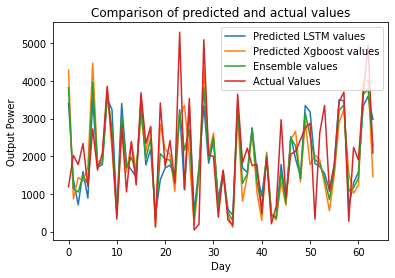

In [37]:
plt.plot(Ypred_lstm)
plt.plot(Ypred_xgboost)
plt.plot(Ypred_ensemble)
plt.plot(Ytest)
plt.title('Comparison of predicted and actual values')
plt.ylabel('Output Power')
plt.xlabel('Day')
plt.legend(['Predicted LSTM values', 'Predicted Xgboost values','Ensemble values','Actual Values'])
plt.show()